In [2070]:
import pandas as pd
import os
import csv
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import catboost
from numpy import percentile
import string
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import f_regression
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

In [1888]:
RANDOM_SEED = 42

In [1889]:
def data_outlier(columns_list, df):

    data_out = pd.DataFrame(data = {'name': [], 'count': [], 'min': [], 'mean': [], 'max': [], 
                                    'low_range': [], 'upper_range': [], 'out_count': []
                                   })
    for column_name in columns_list:
        perc25 = percentile(df[column_name], 25)
        perc75 = percentile(df[column_name], 75)
        iqr = perc75 - perc25
        low_range = perc25 - 1.5 * iqr
        upper_range = perc75 + 1.5 * iqr
        out_count = df[column_name].apply(
            lambda x: None if x < low_range or x > upper_range else x).isna().sum()
        
        to_append = [column_name, df[column_name].count(), round(df[column_name].min(), 2), 
                     round(df[column_name].mean(), 2), round(df[column_name].max(), 2), 
                     round(low_range, 2), round(upper_range, 2), out_count]
        data_out_length = len(data_out)
        data_out.loc[data_out_length] = to_append
    
    data_out = data_out.set_index('name')
        
    return data_out

In [1890]:
# Рассмотрим как распределены числовые признаки в трейне

def train_hist_plot(column_name, df_train):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    new_series_log = np.log(df_train[column_name] + 1)

    ax[0].hist(df_train[column_name], rwidth=0.9, alpha=0.7, bins=15)
    ax[0].set_title(column_name)

    ax[1].hist(new_series_log, rwidth=0.9, alpha=0.7, bins=15)
    ax[1].set_title('log of ' + column_name)

    plt.show()
    
def test_hist_plot(column_name, df_test):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    new_series_log = np.log(df_test[column_name] + 1)

    ax[0].hist(df_test[column_name], rwidth=0.9, alpha=0.7, bins=15)
    ax[0].set_title(column_name)

    ax[1].hist(new_series_log, rwidth=0.9, alpha=0.7, bins=15)
    ax[1].set_title('log of ' + column_name)

    plt.show()

In [1891]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [1892]:
def preproc_data(df_input, num_features, cat_features):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    ################### Numerical Features ##############################################################

    scaler = MinMaxScaler()
    
    for feature in num_features:
         df_output[feature] = scaler.fit_transform(df_output[feature].values.reshape(-1, 1))


    ################### Categorical Features ##############################################################

    for column in cat_features:
         df_output[column] = df_output[column].astype('category').cat.codes
        
    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df_output = pd.get_dummies(df_output, columns=cat_features, dummy_na=False)

    return df_output



In [1893]:
df = pd.read_csv("data_new.csv")

In [1894]:
df.head()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


In [1895]:
df.shape

(377185, 18)

In [1896]:
df[df['target'].isna()].shape

(2481, 18)

In [1897]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

In [1898]:
print("Percent NULL values\n")
round(df.isna().sum() / df.shape[0] * 100, 4)

Percent NULL values



status          10.5831
private pool    98.8915
propertyType     9.2085
street           0.0005
baths           28.1925
homeFacts        0.0000
fireplace       72.6620
city             0.0090
schools          0.0000
sqft            10.7579
zipcode          0.0000
beds            24.2009
state            0.0000
stories         39.9578
mls-id          93.3873
PrivatePool     89.3127
MlsId           17.7314
target           0.6578
dtype: float64

Удаляем столбцы, где процент NULL значений больше 40%

In [1899]:
df.drop(['private pool', 'fireplace', 'mls-id', 'PrivatePool'], axis=1, inplace=True)

In [1900]:
df.nunique()

status             159
propertyType      1280
street          337076
baths              229
homeFacts       321009
city              2026
schools         297365
sqft             25405
zipcode           4549
beds              1184
state               39
stories            348
MlsId           232944
target           43939
dtype: int64

status

In [1901]:
df['status'] = df['status'].str.lower()

In [1902]:
df['status'] = df['status'].str.replace('[{}]'.format(string.punctuation), ' ').str.replace('[{}]'.format(string.digits), ' ').apply(lambda x: " ".join(str(x).split()))
df['status'] = df['status'].apply(lambda x: None if x is None else None if str(x) == 'nan' else x)
df['status'].value_counts(dropna=False)

for sale                                199571
active                                  105207
NaN                                      39918
foreclosure                               6769
new construction                          5475
                                         ...  
under contract taking back up offers         1
temporary active                             1
contingent sale of home                      1
under contract w bckp                        1
contract                                     1
Name: status, Length: 104, dtype: int64

In [1903]:
df['status'].nunique()

103

In [1904]:
df['status'].isna().sum()

39918

propertyType 

In [1905]:
df['propertyType'].sample(10)

110927                   NaN
133237    single-family home
144521         Single Family
103109    single-family home
72423              Townhouse
138454                 Condo
247036         Single Family
26340            Traditional
203849    Single Family Home
114063                   NaN
Name: propertyType, dtype: object

In [1906]:
df['propertyType'] = df['propertyType'].str.lower()
df['propertyType'] = df['propertyType'].str.replace('[{}]'.format(string.punctuation), ' ').apply(lambda x: " ".join(str(x).split()))
df['propertyType'] = df['propertyType'].str.replace('one', '1').str.replace('two', '2')

In [1907]:
df['propertyType'].value_counts()[20:40]

contemporary modern           1010
apartment                      922
2 stories                      911
mfd mobile home                792
single detached                751
detached 2 story               638
2 story                        596
transitional                   560
cooperative                    535
florida                        530
bungalow                       442
farms ranches                  371
garden home                    305
cape cod                       281
2 stories traditional          280
spanish mediterranean          272
other style                    249
1 story traditional            238
other                          232
condo townhome traditional     225
Name: propertyType, dtype: int64

In [1908]:
df['stories_dop'] = df['propertyType'].str.findall(r'[a-z0-9]+ story|[a-z0-9]+ stories').apply(lambda x: None if len(x) == 0 else x[-1])

df['stories_dop'].value_counts(dropna=False)

NaN          369527
1 story        4440
2 stories      1558
2 story        1466
3 stories       134
8 stories        38
7 stories        15
3 story           6
5 story           1
Name: stories_dop, dtype: int64

In [1909]:
set_story = set(df['stories_dop'].dropna())
for y in set_story:
  df['propertyType'] = df['propertyType'].str.replace(y, '')

In [1910]:
df['propertyType'] = df['propertyType'].str.replace('home', '')
df['propertyType'] = df['propertyType'].apply(lambda x: None if x == '' else
                                              None if str(x) == 'nan' else 
                                              None if str(x) == 'None' else " ".join(str(x).split()))

In [1911]:
df['propertyType'].nunique()

1112

In [1912]:
df['propertyType'].value_counts(dropna=False)

single family                     186803
condo                              42530
NaN                                38211
lot land                           20552
townhouse                          18401
                                   ...  
farm house traditional                 1
back to back                           1
cape cottage                           1
condo town a frame traditional         1
contemporary saltbox                   1
Name: propertyType, Length: 1113, dtype: int64

street пока не рарабатываем, сделаем токенайзером

baths

In [1913]:
df['baths'] = df['baths'].apply(lambda x: None if x is np.nan else x)
df['baths'].value_counts(dropna=False)

NaN          106338
2 Baths       52466
3 Baths       35506
2             20452
2.0           16576
              ...  
3.3 Baths         1
23                1
1.8 Baths         1
2.25 ba           1
21 Baths          1
Name: baths, Length: 230, dtype: int64

In [1914]:
punct = '~—\-:'

df['baths'] = df['baths'].str.lower().str.replace('[a-z]+\.?', '').str.replace(',', '.').str.replace('[{}]'.format(punct), ' ')
df['baths'] = df['baths'].apply(lambda x: None if str(x).strip() =='' else x)

In [1915]:
df['baths'] = df['baths'].str.findall('[0-9]+\.?[0-9]*')
df['baths'] = df['baths'].apply(lambda x: None if x is None else x[0]).astype(float)

df['baths'].value_counts(dropna=False)

NaN      107838
2.00     103519
3.00      66683
4.00      26333
1.00      17787
          ...  
43.00         1
4.75          1
60.00         1
6.75          1
42.00         1
Name: baths, Length: 85, dtype: int64

city пока не будем разрабатывать, много уник значений, сделаем токенайзером

sqft

In [1916]:
df['sqft'].value_counts(dropna=False)

NaN                                         40577
0                                           11854
1,200 sqft                                    839
1,000 sqft                                    654
1,100 sqft                                    573
                                            ...  
105,675 sqft                                    1
7,133 sqft                                      1
8,284                                           1
12,201                                          1
Total interior livable area: 10,550 sqft        1
Name: sqft, Length: 25406, dtype: int64

In [1917]:
df['sqft'] = df['sqft'].apply(lambda x: None if x is np.nan else 
                                        None if str(x) == '' else str(x))

In [1918]:
df['sqft'] = df['sqft'].str.replace(',', '')
df['sqft'] = df['sqft'].str.findall('[0-9]+\.?[0-9]*')
df['sqft'] = df['sqft'].apply(lambda x: None if x is None else 
                                        None if len(x) == 0 else int(x[0]))

In [1919]:
df['sqft'].value_counts(dropna=False)

NaN        41397
0.0        11854
1200.0      1426
1000.0      1027
1500.0      1014
           ...  
5883.0         1
47044.0        1
46998.0        1
46996.0        1
9964.0         1
Name: sqft, Length: 9897, dtype: int64

zipcode

In [1920]:
df['zipcode'].value_counts(dropna=False)

32137         2141
33131         1563
34747         1488
78245         1390
34759         1333
              ... 
89504            1
27705-2654       1
37871            1
2138             1
50457            1
Name: zipcode, Length: 4549, dtype: int64

In [1921]:
# Приведем все значения к 5-значному формату

df['zipcode'] = df['zipcode'].str.replace('\-[0-9]*', '').apply(lambda x: None if x is None else 
                                                                None if x == '' else 
                                                                ('0000' + str(x))[-5:])

beds

In [1922]:
df['beds'] = df['beds'].apply(lambda x: None if x is np.nan else x).str.lower()

In [1923]:
df['beds'].value_counts(dropna=False)

NaN           91282
3 beds        53459
4 beds        35418
3             31406
2 beds        26362
              ...  
5.09 acres        1
9,997 sqft        1
4,835 sqft        1
3,325 sqft        1
9,452 sqft        1
Name: beds, Length: 1185, dtype: int64

In [1924]:
# Данные по sqft выделим из столбца beds

index_sqft = df.loc[(df['sqft'].isna()) & (df['beds'].str.contains('sqft')), ['sqft','beds']].index
new_sqft = df.loc[(df['sqft'].isna()) & (df['beds'].str.contains('sqft')), ['sqft','beds']]
new_sqft['sqft'] = new_sqft['beds'].str.strip().str.replace(',', '.').str.findall('[0-9]+\.*[0-9]*').apply(lambda x: None if len(x) == 0 else x[0]).astype(float)

df.loc[(df['sqft'].isna()) & (df['beds'].str.contains('sqft')), 'sqft'] = new_sqft['sqft']
df.loc[(df['beds'].isna()==False) & (df['beds'].str.contains('sqft')), 'beds'] = None

In [1925]:
# Данные по sqft в акрах выделим из столбца beds

index_sqft = df.loc[(df['sqft'].isna()) & (df['beds'].str.contains('acre')), ['sqft','beds']].index
new_sqft = df.loc[(df['sqft'].isna()) & (df['beds'].str.contains('acre')), ['sqft','beds']]
new_sqft['sqft'] = new_sqft['beds'].str.strip().str.replace(',', '.').str.findall('[0-9]+\.*[0-9]*').apply(lambda x: None if len(x) == 0 else x[0]).astype(float)
new_sqft['sqft'] = (new_sqft['sqft'] * 43560).astype(int)

df.loc[(df['sqft'].isna()) & (df['beds'].str.contains('acre')), 'sqft'] = new_sqft['sqft']
df.loc[(df['beds'].isna()==False) & (df['beds'].str.contains('acre')), 'beds'] = None

In [1926]:
df['beds'] = df['beds'].str.replace('bedrooms', 'beds').str.replace('bd', 'beds')
df['beds'] = df['beds'].str.replace('or more ', '').str.replace('#', '').str.replace(r'[0-9]+[a-z]+', '')

In [1927]:
df.loc[(df['beds'].isna()==False) & (df['beds'].str.strip().str.contains('^[a-z,\-%@#_:;~ ]+$')), 'beds'] = None

In [1928]:
# Данные по baths выделим из столбца beds

new_bath = df.loc[(df['baths'].isna()) & (df['beds'].str.contains('bath')), 'beds'].str.findall('[0-9a-z ]+ bath').apply(lambda x: x[0].split()[0]).astype(float)
df.loc[new_bath.index, 'baths'] = new_bath

In [1929]:
df['beds'].isna().sum()

# Уже на данном этапе слишком много пустых значений, удалим данный столбец

111391

state

In [1930]:
df['state'].value_counts(dropna=False)

FL    115449
TX     83786
NY     24479
CA     23386
NC     21862
TN     18340
WA     13826
OH     12588
IL      8939
NV      8482
GA      6705
CO      6404
PA      5561
MI      5161
DC      4674
AZ      3347
IN      3328
OR      2789
MA      1516
UT      1325
MD      1090
VT       868
MO       866
VA       801
WI       452
NJ       436
ME       259
IA       242
KY        90
OK        49
MS        40
SC        28
MT         7
DE         5
BA         1
OS         1
AL         1
OT         1
Fl         1
Name: state, dtype: int64

stories

In [1931]:
df['stories_dop'] = df['stories_dop'].apply(lambda x: None if x is None else x.split()[0]).astype(float)
df['stories_dop'].value_counts(dropna=False)

NaN    369527
1.0      4440
2.0      3024
3.0       140
8.0        38
7.0        15
5.0         1
Name: stories_dop, dtype: int64

In [1932]:
df['stories'] = df['stories'].str.lower()
df['stories'].value_counts(dropna=False)[:10]

# Слишком много пустых значений, даже с учетом добвления stories_dop, удалим оба столбца

NaN    150715
1.0     67454
2.0     55283
1       23086
2       18146
3.0     11275
0.0      7241
one      5758
0        4273
3        4228
Name: stories, dtype: int64

MlsId

In [1933]:
df = df.drop('MlsId', axis=1)

homeFacts

In [1934]:
df['homeFacts'] = df['homeFacts'].apply(lambda x: eval(x)).apply(lambda x: list(x.values())[0])

In [1935]:
list_columns = ['Year built', 'Remodeled year', 'Heating', 'Cooling', 'Parking', 'lotsize', 'Price/sqft']

for column in enumerate(list_columns):
  df[column[1]] = None
  df[column[1]] = df['homeFacts'].apply(lambda x: None if x[column[0]].get('factValue') == '' else  x[column[0]].get('factValue'))

Year built

In [1936]:
df['Year built'].value_counts(dropna=False)

NaN     62374
2019    32171
2006     8008
2005     7503
2007     7152
        ...  
1740        1
1057        1
1019        1
1060        1
1780        1
Name: Year built, Length: 230, dtype: int64

In [1937]:
df.loc[df['Year built'].str.len() > 4, 'Year built'] = None
df.loc[df['Year built'].str.len() < 4, 'Year built'] = None


In [1938]:
df['Year built'] = df['Year built'].apply(lambda x: None if x is None else
                                          None if 'No' in x else 
                                          None if str(x) == 'nan' else
                                          None if str(x) == '' else int(x))

Remodeled year

In [1939]:
df['Remodeled year'].value_counts(dropna=False)

# Слишком много пропусков, удалим потом столбец

NaN     226110
2006      5538
2005      4817
2007      4387
2008      3796
         ...  
1869         1
1862         1
1845         1
1800         1
1846         1
Name: Remodeled year, Length: 154, dtype: int64

Heating

In [1940]:
df['Heating'].value_counts(dropna=False)[:10]

# Слишком много пропусков и непоказательных данных, удалим потом столбец

NaN                 109332
Forced Air           82807
Forced air           51506
Other                29623
Electric             10211
Gas                   9296
No Data               8611
Central Air           7814
Central Electric      7112
Central               6247
Name: Heating, dtype: int64

Cooling

In [1941]:
df['Cooling'].value_counts(dropna=False)

# Слишком много пропусков и непоказательных данных, удалим потом столбец

Central                                   158754
NaN                                       123967
Central Air                                14384
No Data                                    10616
Has Cooling                                 9730
                                           ...  
Baseboard, Radiant                             1
Baseboard - Hotwater                           1
Wall or Window Units, Wall Unit(s)             1
No A/C, Window Unit                            1
Ceiling Fan(s), Central A/C, Zoned A/C         1
Name: Cooling, Length: 1445, dtype: int64

Parking

In [1942]:
df['Parking'].value_counts(dropna=False)[:10]

# Слишком много пропусков и непоказательных данных, удалим потом столбец

NaN                         175420
Attached Garage              70752
2 spaces                     28063
1 space                      14252
No Data                      13334
Detached Garage              13201
Carport                       7743
3 spaces                      4724
Off Street                    3622
Carport, Attached Garage      3025
Name: Parking, dtype: int64

lotsize sqft

In [1943]:
df[['lotsize', 'sqft']].sample(5)

,lotsize,sqft
139911,None,1730.0
106747,871 sqft lot,1001.0
151616,"9,922 sqft",2939.0
305375,"1,666 sqft",1350.0
195235,"8,080 sqft",5217.0


In [1944]:
df['lotsize'] = df['lotsize'].str.lower().str.replace(r'[\-,—]', '').str.strip().apply(lambda x: None if x is None else
                                                                                      None if 'no' in x else
                                                                                      None if x == '' else x)

In [1945]:
# Заполним те значения признака sqft которые пустые из признака lotsize

# acres
new_lot_size = df.loc[(df['sqft'].isna()) & (df['lotsize'].isna()==False) & (df['lotsize'].str.contains('sq'))]['lotsize']
new_lot_size = new_lot_size.str.lower().str.replace(r'[a-z \.]', '').str.strip()
new_lot_size = new_lot_size.apply(lambda x: None if x is None else 
                                  None if x is np.nan else
                                  None if x == '' else int(float(x)))
df.loc[new_lot_size.index, 'sqft'] = new_lot_size

# acres
new_lot_size = df.loc[(df['sqft'].isna()) & (df['lotsize'].isna()==False) & (df['lotsize'].str.contains('acre'))]['lotsize']
new_lot_size = new_lot_size.str.lower().str.replace('[a-z ]', '').str.strip()
new_lot_size = new_lot_size.apply(lambda x: None if x is None else float(x) * 43560).astype(int)
df.loc[new_lot_size.index, 'sqft'] = new_lot_size

In [1946]:
df['sqft'].isna().sum()

11890

Price/sqft

In [1947]:
df['Price/sqft'].sample(10)

29828          $169
84106          None
72298           $74
307748    $497/sqft
95254          $198
10881          $123
37717          None
334524         $252
286761         None
289104    $553/sqft
Name: Price/sqft, dtype: object

In [1948]:
df['Price/sqft'] = df['Price/sqft'].str.lower().str.replace(r'[,/$a-z\. ]', '').str.strip().apply(lambda x: None if x is None else
                                                                                      None if x == '' else int(x))

schools

In [1949]:
df['schools'] = df['schools'].apply(lambda x: eval(x)[0])

In [1950]:
list_keys = ['data', 'name', 'rating']
# name не будем брать

list_columns = ['Distance', 'Grades', 'rating']
# Grades не будем брать слишком запутано

df['Distance'] = df['schools'].apply(lambda x: None if x.get('data').get('Distance') is None else x.get('data').get('Distance'))
df['rating'] = df['schools'].apply(lambda x: None if x.get('rating') is None else x.get('rating'))

In [1951]:
df['Distance'] = df['Distance'].apply(lambda x: [float(y.replace('mi', '').strip()) for y in x])

In [1952]:
df['Distance'] = df['Distance'].apply(lambda x: list(filter(None, x)))

In [1953]:
df['Distance'].sample(10)

369820                                       [6.3]
270677                          [0.36, 1.54, 1.58]
29816     [1.5, 1.4, 5.2, 1.3, 1.5, 3.6, 0.3, 1.5]
198487    [0.8, 1.2, 0.9, 0.4, 0.9, 0.9, 0.7, 0.9]
29070                              [0.3, 0.7, 1.0]
108299                          [2.18, 2.52, 0.87]
221024                         [10.75, 0.23, 0.41]
218614                             [3.0, 2.1, 2.0]
69331                              [1.9, 2.0, 2.3]
94446                           [6.01, 1.92, 0.46]
Name: Distance, dtype: object

In [1954]:
df['rating'] = df['rating'].apply(lambda x: [None if "NR" in str(y) else
                                             None if "None" in str(y) else
                                             None if "NA" in str(y) else
                                             None if str(y) == '' else
                                             int(str(y).split('/')[0]) if "/" in str(y) else
                                             int(y) for y in x])

In [1955]:
df['rating'] = df['rating'].apply(lambda x: list(filter(None, x)))

In [1956]:
df['rating'].sample(10)

227620    [6, 7, 5]
142057    [3, 2, 3]
97959     [3, 5, 4]
317836    [2, 5, 3]
272785    [7, 5, 5]
305295    [4, 7, 4]
281137    [7, 5, 5]
7699      [4, 6, 3]
237058    [4, 5, 3]
318437    [9, 7, 2]
Name: rating, dtype: object

target

In [1957]:
df['target'].value_counts(dropna=False)

NaN          2481
$225,000     1462
$275,000     1355
$250,000     1312
$350,000     1296
             ... 
$233,495+       1
$87,700         1
$469,998        1
$90,829         1
$638,398        1
Name: target, Length: 43940, dtype: int64

In [1958]:
df['target'] = df['target'].apply(lambda x: None if x is np.nan else x)

In [1959]:
punct = '$,+\-/'
df['target'] = df['target'].str.replace('[a-z]', '').str.replace('[{}]'.format(punct), '').str.strip()

In [1960]:
df['target'] = df['target'].apply(lambda x: None if x is None else int(x.split()[0]))

In [1961]:
df['target'].value_counts(dropna=False)

NaN         2481
225000.0    1806
275000.0    1650
250000.0    1644
350000.0    1641
            ... 
9100.0         1
515530.0       1
195050.0       1
780226.0       1
374521.0       1
Name: target, Length: 34233, dtype: int64

target Price/sqft

In [1962]:
# Заполним те значения признака sqft которые пустые из признака Price/sqft и признака target

new_lot_size = df.loc[(df['sqft'].isna()) & (df['target'].isna()==False) & (df['Price/sqft'].isna()==False)][['Price/sqft', 'target']]
new_lot_size['sqft'] = (new_lot_size['target'] / new_lot_size['Price/sqft']).astype(int)
df.loc[new_lot_size.index, 'sqft'] = new_lot_size['sqft']

# Заполним те значения признака Price/sqft которые пустые из признака sqft и признака target

new_prsq = df.loc[(df['sqft'].isna()==False) & (df['target'].isna()==False) & (df['Price/sqft'].isna())][['sqft', 'target']]
new_prsq['Price/sqft'] = round(new_prsq['target'] / new_prsq['sqft'])
df.loc[new_prsq.index, 'Price/sqft'] = new_prsq['Price/sqft']

# future engeneer

In [1963]:
# Сделаем копию исходного датасета для будущей обработки текста

df_text = df.copy()

In [1964]:
df.sample(5)

,status,propertyType,street,baths,homeFacts,city,schools,sqft,zipcode,beds,...,stories_dop,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,Price/sqft,Distance,rating
106661,active,None,9761 Sunrise Lakes Blvd #304,1.5,"[{'factValue': '1979', 'factLabel': 'Year buil...",Sunrise,"{'rating': ['6', '6', '3'], 'data': {'Distance...",850.0,33322,None,...,NaN,1979.0,1980,None,None,None,None,123.0,"[1.0, 0.9, 1.8]","[6, 6, 3]"
12609,for sale,multi family,1014 S Independence Blvd,2.0,"[{'factValue': '1908', 'factLabel': 'Year buil...",Chicago,"{'rating': ['2/10', '1/10', '3/10'], 'data': {...",2839.0,60624,5 beds,...,NaN,1908.0,None,Forced Air,None,3,3125 sqft,26.0,"[0.47, 6.6, 1.05]","[2, 1, 3]"
359415,for sale,condo,1120 N Lake Shore Dr # 6A,2.0,"[{'factValue': '1924', 'factLabel': 'Year buil...",Chicago,"{'rating': ['7/10', '2/10', '1/10'], 'data': {...",1433.0,60611,2,...,NaN,1924.0,None,No Data,No Data,None,None,220.0,"[0.3, 1.0, 6.9]","[7, 2, 1]"
21676,for sale,single family,8843 18th Ave SW,2.0,"[{'factValue': '1963', 'factLabel': 'Year buil...",Seattle,"{'rating': ['6/10', '2/10', '4/10'], 'data': {...",2090.0,98106,4 beds,...,NaN,1963.0,None,Forced Air,Central,Attached Garage,4720 sqft,237.0,"[0.63, 0.47, 0.52]","[6, 2, 4]"
30473,for sale,condo,4111 S Ocean Dr #2611,2.0,"[{'factValue': '2017', 'factLabel': 'Year buil...",Hollywood,"{'rating': ['3/10', '4/10', '3/10'], 'data': {...",1087.0,33019,2 beds,...,NaN,2017.0,2018,Forced Air,Central,None,None,763.0,"[2.77, 3.64, 2.01]","[3, 4, 3]"


In [1965]:
# Доля Null значений в трейне и тесте

print('                Train          Test\n')

train_shape = df[df['target'].isna() == False].shape[0] 
test_shape = df[df['target'].isna()].shape[0]

for x in df.columns:
    train_null = df[df['target'].isna() == False][x].isna().sum()
    test_null = df[df['target'].isna()][x].isna().sum()
    print((x + ':' + ' '*15)[:15] + (str(round(train_null / train_shape * 100, 4)) + ' '*15)[:15] + str(round(test_null / test_shape * 100, 4)))


                Train          Test

status:        10.4768        26.6425
propertyType:  10.1496        7.2551
street:        0.0005         0.0
baths:         28.5164        39.5002
homeFacts:     0.0            0.0
city:          0.0091         0.0
schools:       0.0            0.0
sqft:          3.0437         5.1592
zipcode:       0.0005         0.0
beds:          29.5623        24.9899
state:         0.0            0.0
stories:       39.9766        37.1221
target:        0.0            100.0
stories_dop:   97.9565        99.9597
Year built:    16.8856        13.2608
Remodeled year:60.0124        50.0202
Heating:       28.9962        27.4889
Cooling:       32.8457        35.9936
Parking:       46.5744        36.4369
lotsize:       24.4324        19.6292
Price/sqft:    3.0437         85.8122
Distance:      0.0            0.0
rating:        0.0            0.0


In [1966]:
# Удалим признаки которые не обрабатывали, так как текста
df = df.drop(['street', 'city'], axis=1)

# Удалим признаки ненужные
df = df.drop(['homeFacts', 'schools', 'stories_dop', 'lotsize'], axis=1)

# # Удалим столбцы, в которых много пустых значений либо вообще, либо много пустых значений в тесте
df = df.drop(['stories', 'baths', 'beds', 'Remodeled year', 'Heating', 'Cooling', 'Parking', 'Price/sqft'], axis=1)
df = df.drop(['status'], axis=1)


In [1967]:
# Содаем новые признаки

import numpy as np

df['dist_max'] = df['Distance'].apply(lambda x: None if x is None else 
                                      None if len(x) == 0 else max(x))
df['dist_min'] = df['Distance'].apply(lambda x: None if x is None else 
                                      None if len(x) == 0 else min(x))

In [1968]:
df['rate_max'] = df['rating'].apply(lambda x: None if x is None else 
                                      None if len(x) == 0 else max(x))
df['rate_min'] = df['rating'].apply(lambda x: None if x is None else 
                                      None if len(x) == 0 else min(x))

In [1969]:
df = df.drop(['Distance', 'rating'], axis=1)

# Train Test

In [1970]:
df_train = df[df['target'].isna() == False].copy()
df_test = df[df['target'].isna()].copy()
df_test['target'] = 0

In [1971]:
df_train.head()

,propertyType,sqft,zipcode,state,target,Year built,dist_max,dist_min,rate_max,rate_min
0,single family,2900.0,28387,NC,418000.0,2019.0,12.60,2.70,7.0,4.0
1,single family,1947.0,99216,WA,310000.0,2019.0,1.65,1.01,4.0,4.0
2,single family,3000.0,90049,CA,2895000.0,1961.0,2.63,1.19,8.0,4.0
3,single family,6457.0,75205,TX,2395000.0,2006.0,1.05,0.10,10.0,9.0
4,lot land,10019.0,32908,FL,5000.0,NaN,5.96,3.03,5.0,4.0


In [1972]:
df_train.isna().sum()

# Мало значений null удалим их

propertyType    38031
sqft            11405
zipcode             2
state               0
target              0
Year built      63271
dist_max         4258
dist_min         4258
rate_max         5117
rate_min         5117
dtype: int64

In [1973]:
df_train = df_train.dropna(axis=0)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 285216 entries, 0 to 377184
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   propertyType  285216 non-null  object 
 1   sqft          285216 non-null  float64
 2   zipcode       285216 non-null  object 
 3   state         285216 non-null  object 
 4   target        285216 non-null  float64
 5   Year built    285216 non-null  float64
 6   dist_max      285216 non-null  float64
 7   dist_min      285216 non-null  float64
 8   rate_max      285216 non-null  float64
 9   rate_min      285216 non-null  float64
dtypes: float64(7), object(3)
memory usage: 23.9+ MB


In [1974]:
df_test.isna().sum()

# Мало нулевых значений, заполним их

propertyType    180
sqft            128
zipcode           0
state             0
target            0
Year built      329
dist_max         27
dist_min         27
rate_max         35
rate_min         35
dtype: int64

Заполнение null значение в тесте

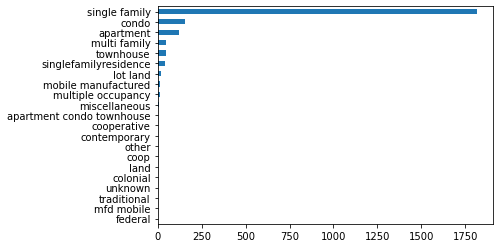

In [1975]:
df_test['propertyType'].value_counts(ascending=True).plot.barh()

In [1976]:
# Заменим null значения
df_test.loc[df_test['propertyType'].isna(), 'propertyType'] = 'other'

In [1977]:
mean_sqft = round(df_test['sqft'].dropna().mean())

df_test.loc[df_test['sqft'].isna(), 'sqft'] = mean_sqft

In [1978]:
mean_dist_max = round(df_test['dist_max'].dropna().mean())

df_test.loc[df_test['dist_max'].isna(), 'dist_max'] = mean_dist_max

In [1979]:
mean_dist_min = round(df_test['dist_min'].dropna().mean())

df_test.loc[df_test['dist_min'].isna(), 'dist_min'] = mean_dist_min

In [1980]:
mean_rate_max = round(df_test['rate_max'].dropna().mean())

df_test.loc[df_test['rate_max'].isna(), 'rate_max'] = mean_rate_max

In [1981]:
mean_rate_min = round(df_test['rate_min'].dropna().mean())

df_test.loc[df_test['rate_min'].isna(), 'rate_min'] = mean_rate_min

In [1982]:
year_mean = round(df_test['Year built'].dropna().mean())

df_test.loc[df_test['Year built'].isna(), 'Year built'] = year_mean

In [1983]:
# Дополнительно выделить столбцы с Null значениями!

Обработка финального датасета

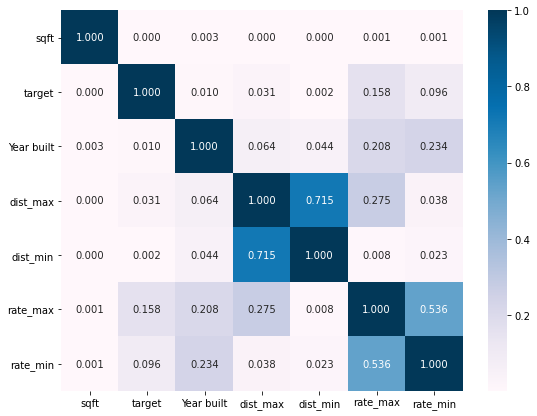

In [1984]:
# Рассмотрим матрицу корреляции для начального удаления сильно скоррелированных признаков

plt.figure(figsize=(9,7))

sns.heatmap(df_train.corr().abs(), annot=True, fmt='.3f', cmap='PuBu')
plt.yticks(rotation=0)
plt.show()

In [1985]:
# Очень сильная корреляция между dist_max и dist_min, возможно потом удалим

In [1986]:
df.columns

Index(['propertyType', 'sqft', 'zipcode', 'state', 'target', 'Year built',
       'dist_max', 'dist_min', 'rate_max', 'rate_min'],
      dtype='object')

In [1987]:
# Задаем типы переменных

categorical_features = ['propertyType', 'zipcode', 'state']
numerical_features = ['sqft', 'Year built', 'dist_max', 'dist_min', 'rate_max', 'rate_min']
value = ['target']

In [1988]:
# Смотрим выбросы в трейне

data_out = data_outlier(numerical_features + value, df_train)
data_out

,count,min,mean,max,low_range,upper_range,out_count
name,,,,,,,
sqft,285216.0,0.00,11464.47,7.959794e+08,-772.00,4700.00,17214.0
Year built,285216.0,1057.00,1979.10,2.025000e+03,1879.50,2083.50,739.0
dist_max,285216.0,0.02,4.91,1.591090e+03,-3.50,10.10,32788.0
dist_min,285216.0,0.01,1.08,1.590380e+03,-0.95,2.49,22413.0
rate_max,285216.0,1.00,6.72,1.000000e+01,-1.00,15.00,0.0
rate_min,285216.0,1.00,3.66,1.000000e+01,-2.50,9.50,474.0
target,285216.0,1.00,652164.19,1.950000e+08,-374500.00,1183900.00,28984.0


# Рассмотрим числовые признаки по-отдельности

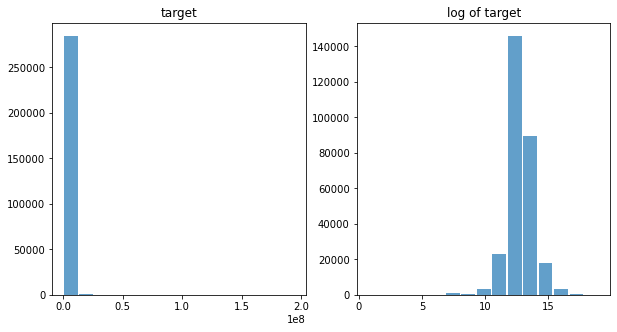

In [1989]:
# target

train_hist_plot('target', df_train)

In [2109]:
df_train = df_train[(df_train['target'] > 1000) & (df_train['target'] < 10_000_000)]

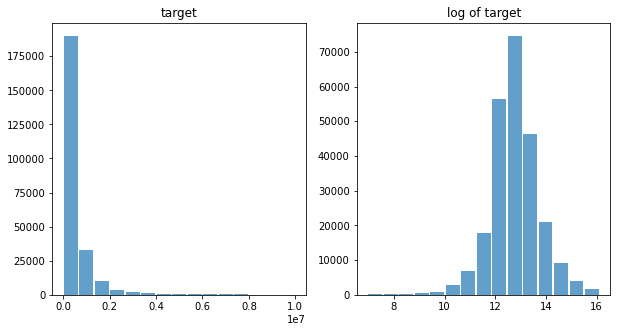

In [2110]:
train_hist_plot('target', df_train[(df_train['target'] > 1000) & (df_train['target'] < 10_000_000)])

In [1990]:
df_train['target_log'] = np.log(df_train['target'] + 1)
df_test['target_log'] = 0

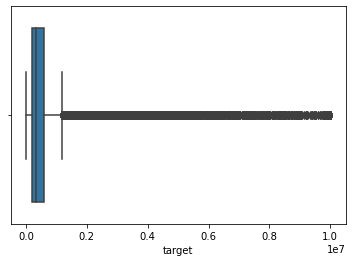

,count,min,mean,max,low_range,upper_range,out_count
target,285216.0,1.0,652164.19,195000000.0,-374500.0,1183900.0,28984.0


In [2111]:
# График выбросов
sns.boxplot(x=df_train["target"])
plt.show()

# Выбросы
data_out.loc['target'].to_frame().T

In [1992]:
# Убираем выбросы
# low_r = data_out.loc['target', 'low_range']
# upp_r = data_out.loc['target', 'upper_range']

# df_train = df_train[(df_train['target'] >= low_r) & (df_train['target'] <= upp_r)]

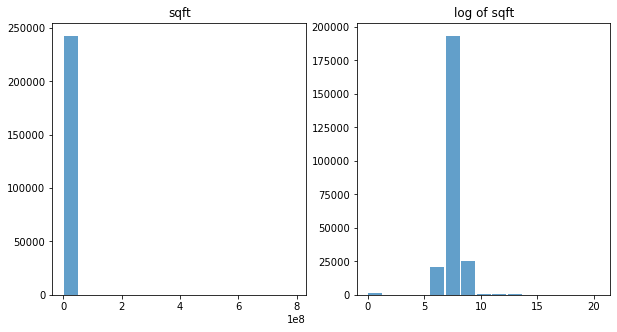

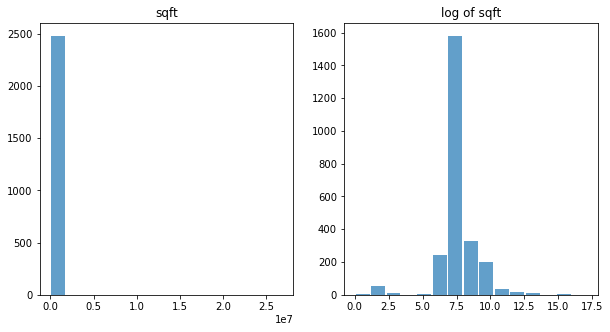

In [2112]:
# sqft
train_hist_plot('sqft', df_train)
test_hist_plot('sqft', df_test)

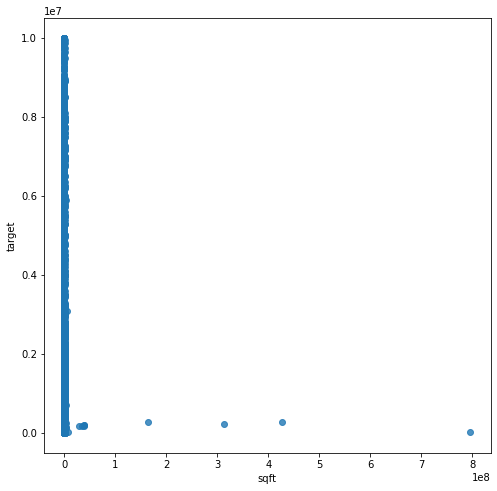

In [2113]:
plt.figure(figsize = (8,8))
sns.regplot(data=df_train, y="target", x="sqft", fit_reg=False)
plt.show()

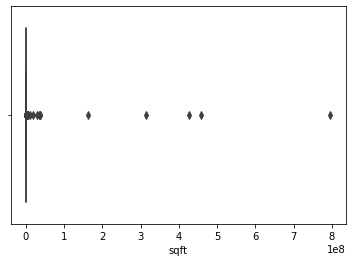

,count,min,mean,max,low_range,upper_range,out_count
sqft,285216.0,0.0,11464.47,795979430.0,-772.0,4700.0,17214.0


In [1995]:
# График выбросов
sns.boxplot(x=df_train["sqft"])
plt.show()

# Выбросы
data_out.loc['sqft'].to_frame().T

In [1996]:
# Удаляем предварительно ненужное
# df_train = df_train[df_train['sqft'] < 10_000_000]

In [1997]:
# Удаляем выбросы

# low_r = data_out.loc['sqft', 'low_range']
# upp_r = data_out.loc['sqft', 'upper_range']

# df_train = df_train[(df_train['sqft'] >= low_r) & (df_train['sqft'] <= upp_r)]

In [1998]:
df_train['sqft_log'] = np.log(df_train['sqft'] + 1)
df_test['sqft_log'] = np.log(df_test['sqft'] + 1)

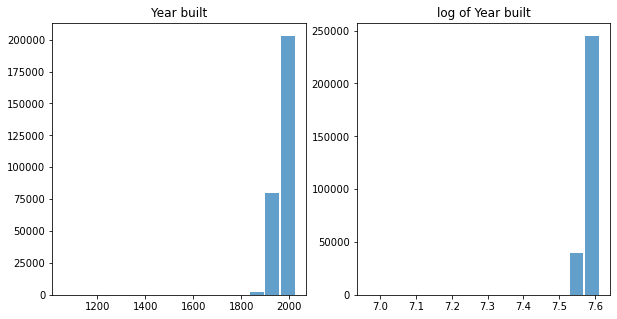

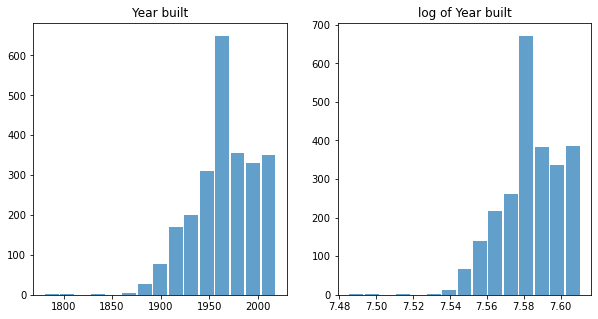

In [1999]:
# Year built

train_hist_plot('Year built', df_train)
test_hist_plot('Year built', df_test)

In [2000]:
min_year_test = df_test['Year built'].min()

# Удалим значения из трейна, не входящие в тест
df_train = df_train[df_train['Year built'] >= min_year_test]

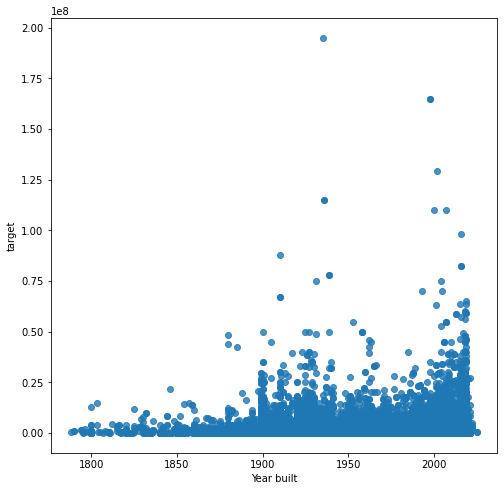

In [2001]:
plt.figure(figsize = (8,8))
sns.regplot(data=df_train, y="target", x="Year built", fit_reg=False)
plt.show()

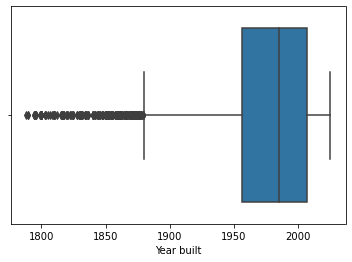

,count,min,mean,max,low_range,upper_range,out_count
Year built,285216.0,1057.0,1979.1,2025.0,1879.5,2083.5,739.0


In [2002]:
# График выбросов
sns.boxplot(x=df_train["Year built"])
plt.show()

# Выбросы
data_out.loc['Year built'].to_frame().T

In [2003]:
df_train['year_built_log'] = np.log(df_train['Year built'] + 1)
df_test['year_built_log'] = np.log(df_test['Year built'] + 1)

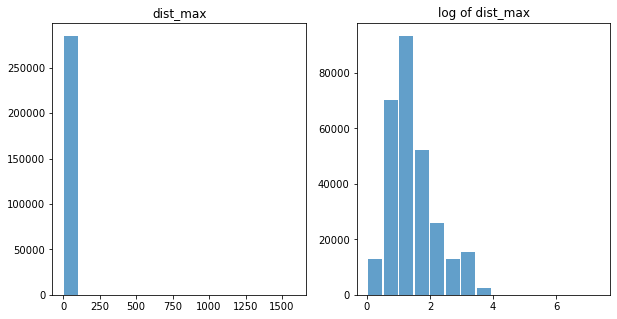

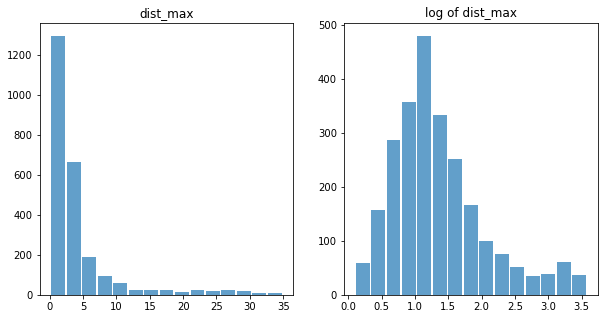

In [2004]:
# dist_max

train_hist_plot('dist_max', df_train)
test_hist_plot('dist_max', df_test)

In [2005]:
df_train['dist_max_log'] = np.log(df_train['dist_max'] + 1)
df_test['dist_max_log'] = np.log(df_test['dist_max'] + 1)

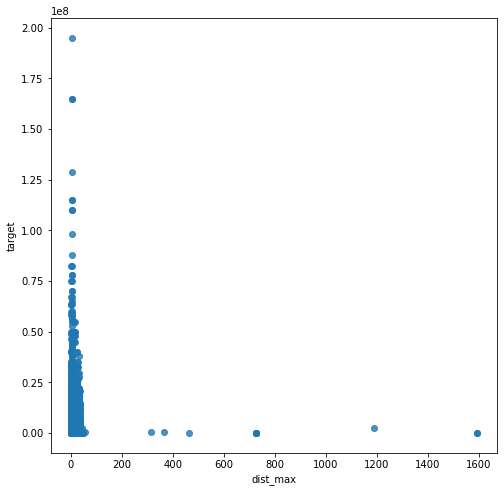

In [2006]:
plt.figure(figsize = (8, 8))
sns.regplot(data=df_train, y="target", x="dist_max", fit_reg=False)
plt.show()

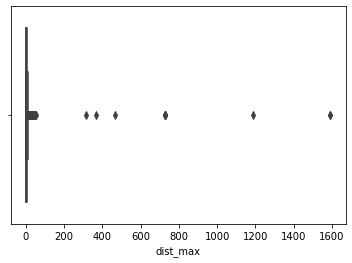

,count,min,mean,max,low_range,upper_range,out_count
dist_max,285216.0,0.02,4.91,1591.09,-3.5,10.1,32788.0


In [2007]:
# График выбросов
sns.boxplot(x=df_train["dist_max"])
plt.show()

# Выбросы
data_out.loc['dist_max'].to_frame().T

In [2008]:
# Удаляем предварительно ненужное

# df_train = df_train[df_train['dist_max'] < 40]

In [2009]:
# Удалим выбросы

# low_r = data_out.loc['dist_max', 'low_range']
# upp_r = data_out.loc['dist_max', 'upper_range']

# df_train = df_train[(df_train['dist_max'] >= low_r) & (df_train['dist_max'] <= upp_r)]

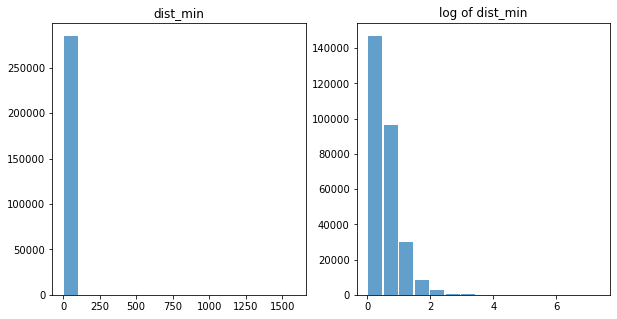

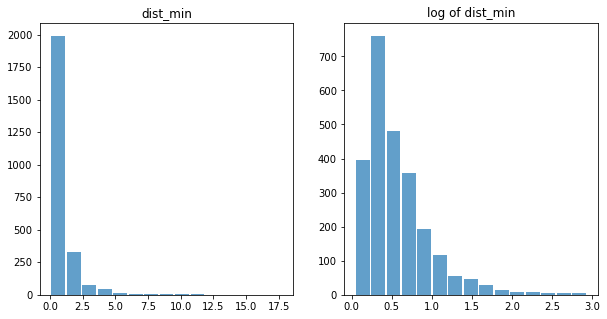

In [2010]:
# dist_min

train_hist_plot('dist_min', df_train)
test_hist_plot('dist_min', df_test)

In [2011]:
df_train['dist_min_log'] = np.log(df_train['dist_min'] + 1)
df_test['dist_min_log'] = np.log(df_test['dist_min'] + 1)

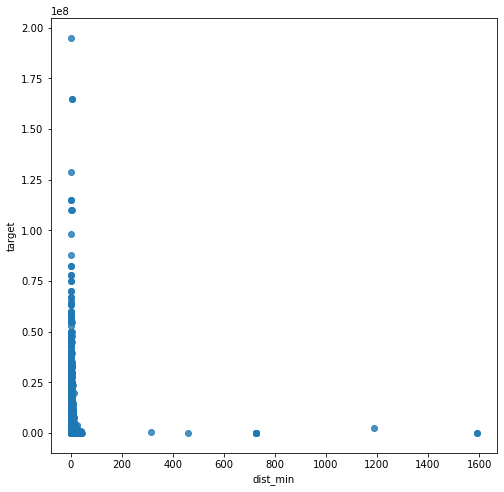

In [2012]:
plt.figure(figsize = (8, 8))
sns.regplot(data=df_train, y="target", x="dist_min", fit_reg=False)
plt.show()

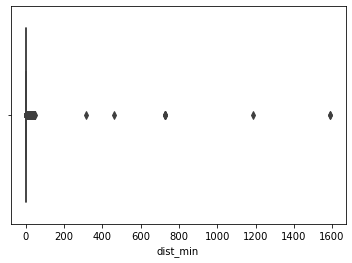

,count,min,mean,max,low_range,upper_range,out_count
dist_min,285216.0,0.01,1.08,1590.38,-0.95,2.49,22413.0


In [2013]:
# График выбросов
sns.boxplot(x=df_train["dist_min"])
plt.show()

# Выбросы
data_out.loc['dist_min'].to_frame().T

In [2014]:
# Удаляем предварительно ненужное

# df_train = df_train[df_train['dist_min'] < 30]

In [2015]:
# Удалим выбросы

# low_r = data_out.loc['dist_min', 'low_range']
# upp_r = data_out.loc['dist_min', 'upper_range']

# df_train = df_train[(df_train['dist_min'] >= low_r) & (df_train['dist_min'] <= upp_r)]

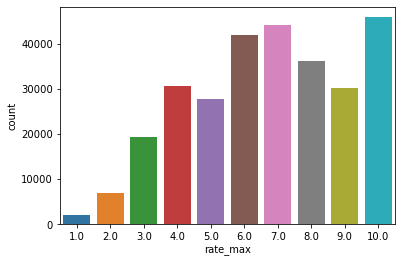

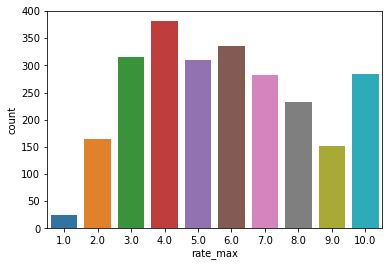

In [2016]:
# rate_max

sns.countplot(x=df_train["rate_max"], data=df_train)
plt.show()

sns.countplot(x=df_test["rate_max"], data=df_test)
plt.show()

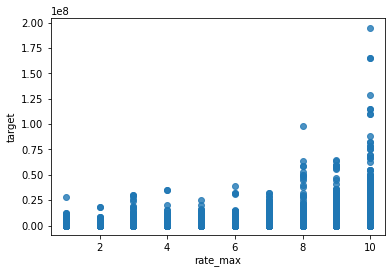

In [2017]:
sns.regplot(data=df_train, y="target", x="rate_max", fit_reg=False)
plt.show()

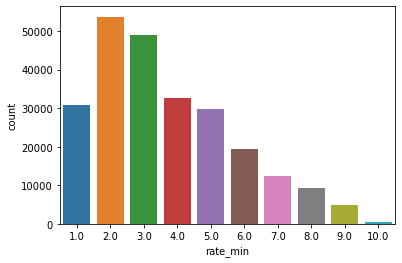

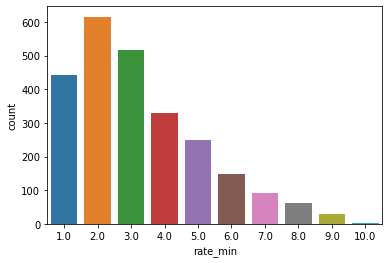

In [2114]:
# rate_min

sns.countplot(x=df_train["rate_min"], data=df_train)
plt.show()

sns.countplot(x=df_test["rate_min"], data=df_test)
plt.show()

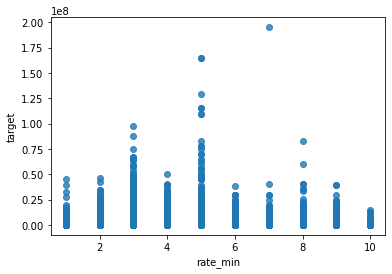

In [2019]:
sns.regplot(data=df_train, y="target", x="rate_min", fit_reg=False)
plt.show()

In [2020]:
# Работа с таргетом  ?

# Влияние числовых признаков на target

In [2021]:
display(df_train.columns)
print(numerical_features)

Index(['propertyType', 'sqft', 'zipcode', 'state', 'target', 'Year built',
       'dist_max', 'dist_min', 'rate_max', 'rate_min', 'target_log',
       'sqft_log', 'year_built_log', 'dist_max_log', 'dist_min_log'],
      dtype='object')

['sqft', 'Year built', 'dist_max', 'dist_min', 'rate_max', 'rate_min']


In [2022]:
# Введем новые числовые признаки
numerical_features = numerical_features + ['sqft_log', 'year_built_log', 'dist_max_log', 'dist_min_log']

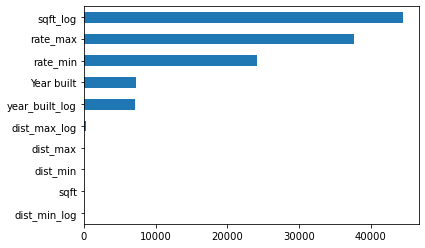

In [2023]:
# График влияния числовых переменных на target

df_train_imp = df_train.copy()

# рассмотрим значимость переменных

imp_num = pd.Series(f_regression(df_train_imp[numerical_features], 
                              df_train_imp['target_log'])[0], index=numerical_features)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [2024]:
# График влияния числовых переменных на target

# df_train_imp = df_train.copy()

# # рассмотрим значимость переменных
# label_encoder = LabelEncoder()

# imp_num = pd.Series(mutual_info_regression(df_train_imp[numerical_features_new], 
#                               df_train_imp['target_log']), index=numerical_features_new)
# imp_num.sort_values(inplace = True)
# imp_num.plot(kind = 'barh')

# Рассмотрим категориальные переменные

In [2025]:
df_train['propertyType'].value_counts()

single family                               169125
condo                                        39636
townhouse                                    15891
multi family                                 11515
condo town row co op                          7354
                                             ...  
contemporary victorian                           1
condo town split level traditional tudor         1
traditional carriage house victorian             1
charleston craftsman                             1
traditional craftsman                            1
Name: propertyType, Length: 1075, dtype: int64

In [2026]:
df_test['propertyType'].value_counts()

single family                1814
other                         181
condo                         157
apartment                     124
multi family                   48
townhouse                      48
singlefamilyresidence          41
lot land                       20
mobile manufactured            15
multiple occupancy             13
miscellaneous                   8
apartment condo townhouse       2
cooperative                     2
contemporary                    1
coop                            1
land                            1
colonial                        1
unknown                         1
traditional                     1
mfd mobile                      1
federal                         1
Name: propertyType, dtype: int64

In [2027]:
unique_train_type = df_train['propertyType'].unique()

df_test[~df_test['propertyType'].isin(unique_train_type)]['propertyType'].value_counts()

singlefamilyresidence        41
apartment condo townhouse     2
Name: propertyType, dtype: int64

In [2028]:
# Так как количетсво этих значений мало, заменим на аналогичное из теста

df_test.loc[df_test['propertyType'] == 'apartment condo townhouse', 'propertyType'] = 'apartment'
df_test.loc[df_test['propertyType'] == 'singlefamilyresidence', 'propertyType'] = 'single family'

In [2029]:
unique_type = df_test['propertyType'].unique()

# Удалим строки из трейна, где нет значений из теста
df_train = df_train[df_train['propertyType'].isin(unique_type)]

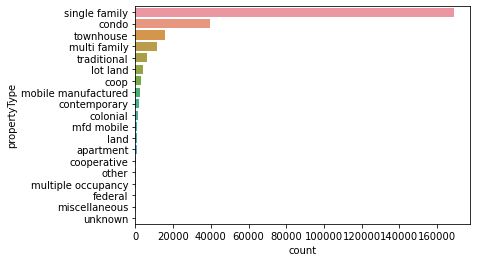

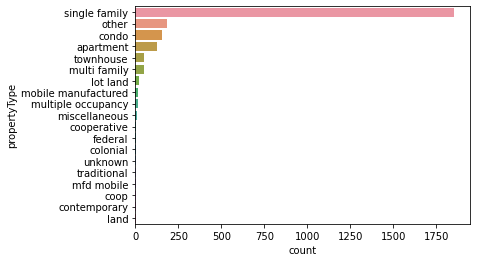

In [2030]:
# Посмотрим как распределены значения в трейне и тесте

sns.countplot(y="propertyType", data=df_train, order = df_train['propertyType'].value_counts().index)
plt.show()

sns.countplot(y="propertyType", data=df_test, order = df_test['propertyType'].value_counts().index)
plt.show()

In [2031]:
# В дальнейшем можно будет упростить значения, чтобы не было такого разброса

In [2032]:
df_train['zipcode'].value_counts()

33131    1275
33132    1025
33137     992
32137     911
33130     911
         ... 
20841       1
61528       1
90630       1
98380       1
50457       1
Name: zipcode, Length: 4045, dtype: int64

In [2033]:
df_test['zipcode'].value_counts()

20019    22
33647    20
11201    19
32209    18
33712    17
         ..
95206     1
27604     1
77581     1
11418     1
27705     1
Name: zipcode, Length: 1163, dtype: int64

In [2034]:
# Так как количество уникальных значений слишком много, разделим из согласно правилу 3-2

df_train.loc[:,'zip_f'] = df_train['zipcode'].apply(lambda x: str(x)[:3])
df_test.loc[:,'zip_f'] = df_test['zipcode'].apply(lambda x: str(x)[:3])

df_train.loc[:,'zip_s'] = df_train['zipcode'].apply(lambda x: str(x)[3:])
df_test.loc[:,'zip_s'] = df_test['zipcode'].apply(lambda x: str(x)[3:])


In [2035]:
# Удалим те строки в трейне, которых нет в тесте

unique_zipf = df_test['zip_f'].unique()
unique_zips = df_test['zip_s'].unique()

df_train = df_train[df_train['zip_f'].isin(unique_zipf)]
df_train = df_train[df_train['zip_s'].isin(unique_zips)]


In [2036]:
# Нужно будет сократить количество уникальных значений, их сильно много

# Ввести новые признаки в датафрейм

In [2037]:
df_train['state'].value_counts()

FL    73329
TX    54475
CA    18919
NY    15351
NC    11541
TN    10314
WA     9548
OH     8537
NV     7296
IL     6968
GA     4827
PA     4442
CO     3753
MI     3630
DC     3225
IN     2436
OR     2327
UT     1054
MO      737
MA      709
MD      669
VT      385
VA       91
ME       57
DE        2
Name: state, dtype: int64

In [2038]:
df_test['state'].value_counts()

FL    782
TX    428
CA    178
OH    156
NY    140
TN    109
DC     89
IL     87
WA     87
NC     76
GA     64
NV     61
PA     51
MI     35
MO     34
IN     34
CO     27
MA     18
OR     11
MD      4
UT      4
VT      4
VA      1
ME      1
Name: state, dtype: int64

In [2039]:
# Посмотрим каких значений теста нет в трейне

unique_train_state = df_train['state'].unique()

df_test[~df_test['state'].isin(unique_train_state)]['state'].value_counts()

Series([], Name: state, dtype: int64)

In [2040]:
# Удалим те строки в трейне, которых нет в тесте

unique_state = df_test['state'].unique()

df_train = df_train[df_train['state'].isin(unique_state)]


In [2041]:
# Добавим новые категориальные признаки

categorical_features = categorical_features + ['zip_f', 'zip_s']

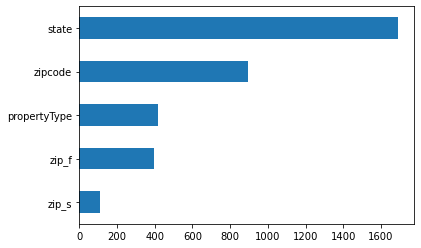

In [2042]:
# Теперь рассмотрим значимость категориальных переменных
df_train_cat = df_train.copy()

label_encoder = LabelEncoder()

for feature in categorical_features:
    df_train_cat[feature] = label_encoder.fit_transform(df_train_cat[feature])

imp_cat = pd.Series(f_regression(df_train_cat[categorical_features], 
                              df_train_cat['target_log'])[0], index=categorical_features)

imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [2043]:
# Замечание: влияние кат переменных на target и target_log разное

In [2044]:
# # Теперь рассмотрим значимость категориальных переменных

# df_train_cat = df_train.copy()

# # рассмотрим значимость переменных
# label_encoder = LabelEncoder()

# for feature in categorical_features:
#     df_train_cat[feature] = label_encoder.fit_transform(df_train_cat[feature])

# imp_cat = pd.Series(mutual_info_regression(df_train_cat[categorical_features], 
#                               df_train_cat['target_log']), index=numerical_features_new)
# imp_cat.sort_values(inplace = True)
# imp_cat.plot(kind = 'barh')

Prepocess data

In [2127]:
numerical_features_copy = numerical_features.copy()
categorical_features_copy = categorical_features.copy()

In [2128]:
# Удаляем признаки из numerical_features_new
for x in ['sqft', 'dist_max', 'dist_min', 'rate_max', 'rate_min', 'year_built_log']:
    numerical_features_copy.remove(x)

# Возможно добавить year_built в категориальные переменные

categorical_features_copy.remove('zipcode')
categorical_features_copy.remove('propertyType')

for x in ['rate_max', 'rate_min']:
    categorical_features_copy.append(x)
    
features = numerical_features_copy + categorical_features_copy + ['target_log']
# features = numerical_features_new + categorical_features + ['target']

In [2129]:
# Мы знаем, что у трейна нет target=0, все эти данные в тесте, поэтому можем легко их оюъединить

df_input = pd.concat([df_train[features], df_test[features]])

In [2130]:
df_input.sample(5)

,Year built,sqft_log,dist_max_log,dist_min_log,propertyType,state,zip_f,zip_s,rate_max,rate_min,target_log
82364,2019.0,8.366603,1.736951,1.029619,single family,GA,303,17,4.0,3.0,13.742833
332917,2001.0,7.793999,0.512824,0.285179,single family,TX,782,47,6.0,3.0,12.388398
18879,1998.0,8.100161,1.308333,0.405465,single family,TX,782,58,10.0,9.0,12.883855
318732,1996.0,7.151485,1.913977,1.360977,single family,FL,342,31,7.0,7.0,12.560248
103366,1964.0,7.776954,0.947789,0.190620,single family,TX,770,48,3.0,2.0,12.278398


df_preproc = preproc_data(data)

In [2131]:
df_preproc = preproc_data(df_input, numerical_features_copy, categorical_features_copy)

In [2132]:
df_preproc.shape

(245112, 378)

In [2133]:
# Возможно, потом удалим выбросы из трейна

Split data

In [2134]:
# Теперь выделим тестовую часть
train_data = df_preproc[df_preproc['target_log'] != 0]
test_data = df_preproc[df_preproc['target_log'] == 0]

X = train_data.drop(['target_log'], axis=1).values
Y = train_data['target_log'].values
X_sub = test_data.drop(['target_log'], axis=1)


# train_data = df_preproc[df_preproc['target'] != 0]
# test_data = df_preproc[df_preproc['target'] == 0]

# X = train_data.drop(['target'], axis=1).values
# Y = train_data['target'].values
# X_sub = test_data.drop(['target'], axis=1)

# CatBoostRegressor

In [2135]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, shuffle=True, random_state=RANDOM_SEED)

# Птом можно будет сделать кросс-валидацию

In [2136]:
model = CatBoostRegressor(iterations = 1000,
                          #depth=10,
                          learning_rate = 0.1,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE'],
                          od_wait=100,
                          #task_type='GPU',
                         )

model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         #plot=True
         )


0:	learn: 0.0541205	test: 0.0537651	best: 0.0537651 (0)	total: 31.7ms	remaining: 31.6s
100:	learn: 0.0303860	test: 0.0300651	best: 0.0300651 (100)	total: 2.98s	remaining: 26.5s
200:	learn: 0.0275687	test: 0.0272865	best: 0.0272865 (200)	total: 5.77s	remaining: 22.9s
300:	learn: 0.0259704	test: 0.0257377	best: 0.0257377 (300)	total: 8.92s	remaining: 20.7s
400:	learn: 0.0249292	test: 0.0247625	best: 0.0247625 (400)	total: 12.1s	remaining: 18.1s
500:	learn: 0.0241714	test: 0.0240730	best: 0.0240730 (500)	total: 15.2s	remaining: 15.2s
600:	learn: 0.0235336	test: 0.0234876	best: 0.0234876 (600)	total: 18.4s	remaining: 12.2s
700:	learn: 0.0230319	test: 0.0230457	best: 0.0230457 (700)	total: 21.5s	remaining: 9.17s
800:	learn: 0.0225825	test: 0.0226527	best: 0.0226527 (800)	total: 24.6s	remaining: 6.12s
900:	learn: 0.0221856	test: 0.0223175	best: 0.0223175 (900)	total: 27.7s	remaining: 3.05s
999:	learn: 0.0218591	test: 0.0220394	best: 0.0220394 (999)	total: 30.8s	remaining: 0us

bestTest = 0.0

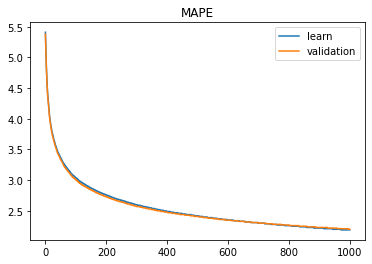

In [2137]:
# model.evals_result_['learn']['MAPE']
# validation

learn_mape = [round(x * 100, 2) for x in model.evals_result_['learn']['MAPE']]
valid_mape = [round(x * 100, 2) for x in model.evals_result_['validation']['MAPE']]

# plt.figure(figsize=(15, 7))
plt.title('MAPE')
plt.plot(learn_mape, label='learn')
plt.plot(valid_mape, label='validation')
plt.legend()
plt.show()




In [2138]:
y_pred = model.predict(X_test)

# print(f"TEST mape: {(mape(y_test, y_pred))*100:0.2f}%")

y_pred_exp = np.round(np.exp(y_pred) - 1)
y_test_exp = np.round(np.exp(y_test) - 1)

print(f"TEST mape: {(mape(y_test_exp, y_pred_exp))*100:0.2f}%")

TEST mape: 46.76%


# RandomForestRegressor

In [2095]:
model = RandomForestRegressor(random_state=RANDOM_SEED)

# Обучаем модель на тестовом наборе данных
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)

# Преобразуем Y_test, y_pred к exp значениям для оценки MAPE

y_pred_exp = np.round(np.exp(y_pred) - 1)
y_test_exp = np.round(np.exp(y_test) - 1)

# Вывод результата MAPE
print(f"TEST mape: {(mape(y_test_exp, y_pred_exp))*100:0.2f}%")

KeyboardInterrupt: 

In [ ]:
# Смещение и дисперсия

# mse = round(np.mean(np.square(y_test_exp - y_pred_exp)))
# rmse = round(np.sqrt(mse))

# var = round(np.var(y_pred_exp))
# bias = round(np.mean(y_pred_exp - y_test_exp))

# print("MSE result:", mse)
# print("RMSE result:", rmse)
# print("VAR result:", var)
# print("bias result:", bias)
# print("Decomposed result:", var + bias*bias)

In [ ]:
price_out = pd.DataFrame(list(zip(y_pred_exp, y_test_exp)), columns = ['y_pred_exp', 'y_test_exp'])
# price_out.to_csv('price_out.csv')